In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc, mean_squared_error, recall_score, precision_score, f1_score
import seaborn as sns
import torch
from kan import KAN
import matplotlib.pyplot as plt

import scikitplot as skplt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, average_precision_score


In [2]:
validation_df = pd.read_csv('dataset_tratado/validation_df.csv')
train_df = pd.read_csv('dataset_tratado/train_df.csv')
test_df = pd.read_csv('dataset_tratado/train_df.csv')

In [3]:
train_df.head()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Class_Eco,Class_Eco Plus,Departure Delay Category_10 minutos até 30 minutos,Departure Delay Category_30 min até 1 hora,Departure Delay Category_Mais de 1 hora,Departure Delay Category_Menos de 10 minutos,Arrival Delay Category_10 minutos até 30 minutos,Arrival Delay Category_30 min até 1 hora,Arrival Delay Category_Mais de 1 hora,Arrival Delay Category_Menos de 10 minutos
0,0.307692,0.052302,0.8,1.0,1.0,0.6,0.4,1.0,0.4,0.4,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.564103,0.511712,0.4,0.4,0.4,0.4,0.6,0.8,1.0,0.8,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.551282,0.073506,0.4,0.4,0.4,0.4,0.8,0.4,0.6,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.256410,0.270800,0.8,0.8,0.8,0.6,0.4,0.8,0.4,0.4,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.294872,0.188611,1.0,0.2,0.2,0.2,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [4]:
X_train = train_df.drop(columns=['satisfied']).values
y_train = train_df['satisfied'].values

In [5]:
X_test = test_df.drop(columns=['satisfied']).values
y_test = test_df['satisfied'].values

## Transformando os dataframes em tensores

In [6]:
train_input = torch.tensor(X_train, dtype=torch.float32)
train_label = torch.tensor(y_train, dtype=torch.long)

In [7]:
test_input = torch.tensor(X_test, dtype=torch.float32)
test_label = torch.tensor(y_test, dtype=torch.long)

In [8]:
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}

## Inicializando e treinando a rede KAN

In [9]:
model = KAN(width=[X_train.shape[1], 2], grid=3, k=3)

Directory already exists: ./model


In [10]:
def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

In [11]:
results = model.train(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())

train loss: 4.19e-01 | test loss: 4.19e-01 | reg: 4.79e+01 : 100%|██| 20/20 [05:59<00:00, 18.00s/it]


Resultados

In [12]:
def extract_final_losses(results):
    """Função para extrair o melhor loss de treino e validação.
    
    Argumento(s):
    results -- Dicionário contendo as perdas de treino e validação durante o treinamento.
    
    Retorno:
    Dicionário contendo o menor loss de treino e de validação.
    """
    train_loss = results['train_loss']
    val_loss = results['test_loss']
    idx_min_val_loss = np.argmin(val_loss)
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(results):
    """Função para plotar as curvas de erro do treinamento da rede neural KAN.
    
    Argumento(s):
    results -- Dicionário contendo as perdas de treino e validação durante o treinamento.
    
    Retorno:
    A função gera o gráfico do treino da rede e retorna None.
    """
    train_loss = results['train_loss']
    val_loss = results['test_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Test Error Curves', xlabel='Steps', ylabel='Loss')
    ax.legend()
    plt.show()


def compute_performance_metrics(y_test, y_pred_class, y_pred_scores=None):
    """Calcula as métricas de desempenho e plota a estatística KS.
    
    Argumento(s):
    y_test -- Rótulos verdadeiros.
    y_pred_class -- Rótulos preditos.
    y_pred_scores -- Pontuações preditas (opcional).
    
    Retorno:
    Tupla contendo as métricas de desempenho.
    """
    # Calcular acurácia
    accuracy = accuracy_score(y_test, y_pred_class)
    
    # Calcular precisão, recall e F1-score
    recall = recall_score(y_test, y_pred_class)
    precision = precision_score(y_test, y_pred_class)
    f1 = f1_score(y_test, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y_test, y_pred_scores)
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y_test, y_pred_scores)
        aupr = average_precision_score(y_test, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    
    return performance_metrics

def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    """Imprime um resumo das métricas de desempenho.
    
    Argumento(s):
    accuracy -- Acurácia.
    recall -- Recall.
    precision -- Precisão.
    f1 -- F1-score.
    auroc -- AUROC (opcional).
    aupr -- AUPR (opcional).
    
    Retorno:
    A função imprime as métricas e retorna None.
    """
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

Acurácia final no conjunto de treino: 0.9351
Acurácia final no conjunto de teste: 0.9351
MSE: 0.0648804024227492
Test Recall: 0.9152577441475526
Test Precision: 0.9339747843397479
Test F1-Score: 0.9245215418147076


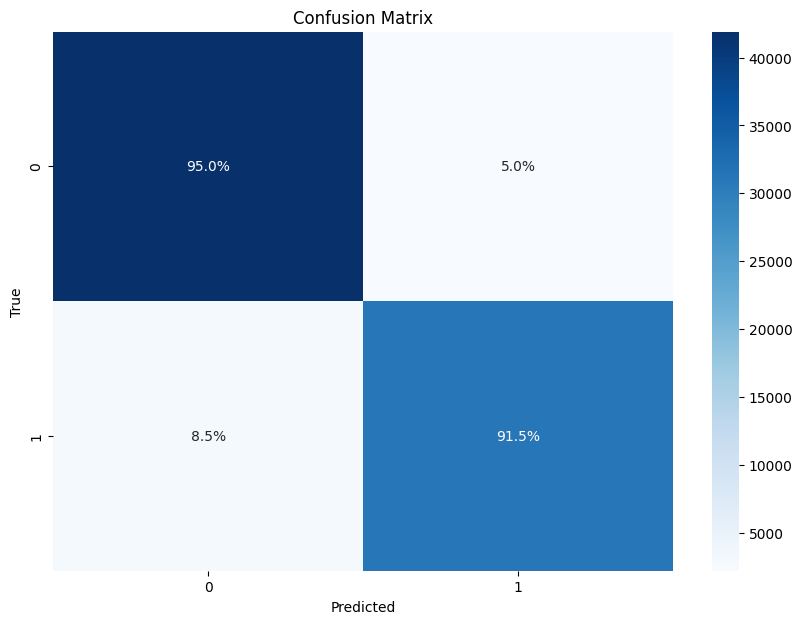

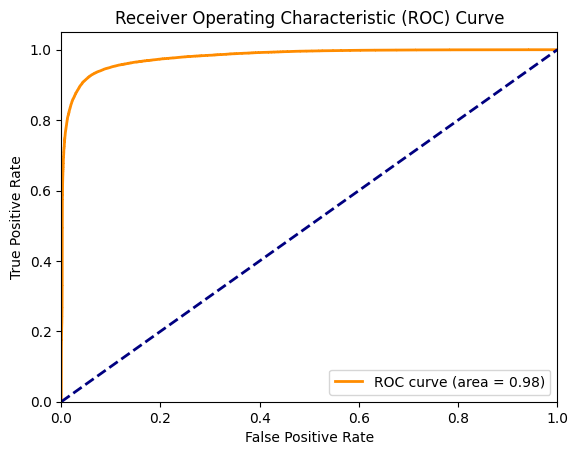

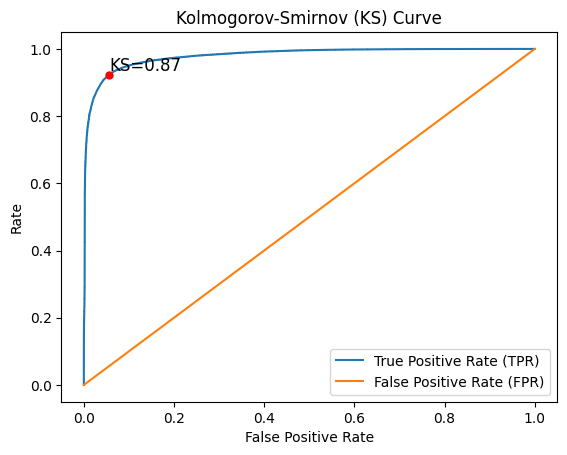

KS Statistic: 0.87
Final Training Loss: 0.41887438
Final test Loss: 0.41887438


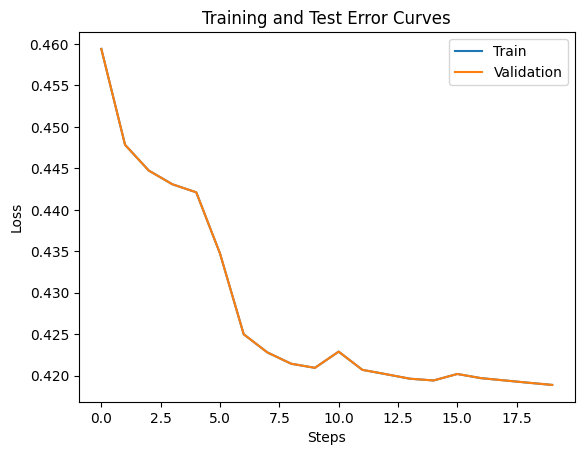

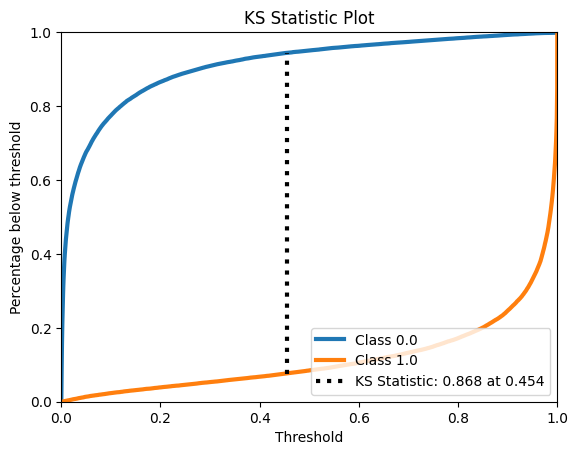


Accuracy:         0.9351
Recall:           0.9153
Precision:        0.9340
F1:               0.9245
AUROC:            0.9799
AUPR:             0.9760


In [13]:
# Avaliação do modelo final
final_train_acc = results['train_acc'][-1]
final_test_acc = results['test_acc'][-1]
print(f"Acurácia final no conjunto de treino: {final_train_acc:.4f}")
print(f"Acurácia final no conjunto de teste: {final_test_acc:.4f}")

# Cálculo do MSE e outras métricas
test_outputs = model(dataset['test_input'])
test_predictions = torch.argmax(test_outputs, dim=1).numpy()
mse = mean_squared_error(y_test, test_predictions)
print(f"MSE: {mse}")

test_recall = recall_score(y_test, test_predictions)
print("Test Recall:", test_recall)

test_precision = precision_score(y_test, test_predictions)
print("Test Precision:", test_precision)

test_f1 = f1_score(y_test, test_predictions)
print("Test F1-Score:", test_f1)

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, test_predictions)
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100
annot_labels = [['{:.1f}%'.format(value) for value in row] for row in conf_matrix_percent]
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=annot_labels, fmt='', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Curva ROC e KS Statistic
test_probs = torch.softmax(test_outputs, dim=1).detach().numpy()
fpr, tpr, _ = roc_curve(y_test, test_probs[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

ks_statistic = np.max(tpr - fpr)
ks_idx = np.argmax(tpr - fpr)
plt.figure()
plt.plot(fpr, tpr, label='True Positive Rate (TPR)')
plt.plot(fpr, fpr, label='False Positive Rate (FPR)')
plt.plot([fpr[ks_idx]], [tpr[ks_idx]], marker='o', markersize=5, color="red")
plt.text(fpr[ks_idx], tpr[ks_idx], f'KS={ks_statistic:.2f}', fontsize=12, verticalalignment='bottom')
plt.xlabel('False Positive Rate')
plt.ylabel('Rate')
plt.title('Kolmogorov-Smirnov (KS) Curve')
plt.legend(loc='best')
plt.show()

print(f"KS Statistic: {ks_statistic:.2f}")

# Utilização das funções auxiliares
losses = extract_final_losses(results)
print("Final Training Loss:", losses['train_loss'])
print("Final test Loss:", losses['val_loss'])

plot_training_error_curves(results)

# Cálculo das métricas de desempenho
performance_metrics = compute_performance_metrics(y_test, test_predictions, test_probs)
print_metrics_summary(*performance_metrics)


## Grid Search

In [27]:
def train_and_evaluate_model(width, grid, k, steps, opt):
    model = KAN(width=width, grid=grid, k=k)

    # Funções de avaliação
    def train_acc():
        return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

    def test_acc():
        return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

    results = model.train(dataset, opt=opt, steps=steps, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())
    final_train_acc = results['train_acc'][-1]
    final_test_acc = results['test_acc'][-1]
    return final_train_acc, final_test_acc

Definindo a grade de busca

In [28]:
param_grid = {
    'width': [[X_train.shape[1], 2]],
    'grid': [2, 3, 4],
    'k': [2, 3, 4],
    'steps': [10, 20, 30, 50, 100],
    'opt' : ['LBFGS', 'Adam']
}

In [32]:
best_params = None
best_accuracy = 0

# Iterar sobre todas as combinações de hiperparâmetros
for width in param_grid['width']:
    for grid in param_grid['grid']:
        for k in param_grid['k']:
            for opt in param_grid['opt']:
                for steps in param_grid['steps']:
                    train_acc, test_acc = train_and_evaluate_model(width, grid, k, steps, opt)
                    print(f"Width: {width}, Grid: {grid}, K: {k}, Steps: {steps}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
                    
                    if test_acc > best_accuracy:
                        best_accuracy = test_acc
                        best_params = {'width': width, 'grid': grid, 'k': k, 'steps': steps, 'opt':opt}

Analise da combinação de parâmetros escolhida

In [33]:
print(f"Best parameters: {best_params}")
print(f"Best test accuracy: {best_accuracy:.4f}")

Treinamento com os parametros escolhidos no Grid Search

In [34]:
final_model = KAN(width=best_params['width'], grid=best_params['grid'], k=best_params['k'])


In [37]:
# Funções de avaliação
def train_acc():
    return torch.mean((torch.argmax(final_model(dataset['train_input']), dim=1) == dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(final_model(dataset['test_input']), dim=1) == dataset['test_label']).float())

results = final_model.train(dataset, opt=best_params['opt'], steps=best_params['steps'], metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())

Avaliação do modelo treinado

In [38]:
final_model.plot()

In [42]:
# Avaliação do modelo final
final_train_acc = results['train_acc'][-1]
final_test_acc = results['test_acc'][-1]
print(f"Acurácia final no conjunto de treino: {final_train_acc:.4f}")
print(f"Acurácia final no conjunto de teste: {final_test_acc:.4f}")

# Cálculo do MSE e outras métricas
test_outputs = final_model(dataset['test_input'])
test_predictions = torch.argmax(test_outputs, dim=1).numpy()
mse = mean_squared_error(y_test, test_predictions)
print(f"MSE: {mse}")

test_recall = recall_score(y_test, test_predictions)
print("Test Recall:", test_recall)

test_precision = precision_score(y_test, test_predictions)
print("Test Precision:", test_precision)

test_f1 = f1_score(y_test, test_predictions)
print("Test F1-Score:", test_f1)

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, test_predictions)
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100
annot_labels = [['{:.1f}%'.format(value) for value in row] for row in conf_matrix_percent]
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=annot_labels, fmt='', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Curva ROC e KS Statistic
test_probs = torch.softmax(test_outputs, dim=1).detach().numpy()
fpr, tpr, _ = roc_curve(y_test, test_probs[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

ks_statistic = np.max(tpr - fpr)
ks_idx = np.argmax(tpr - fpr)
plt.figure()
plt.plot(fpr, tpr, label='True Positive Rate (TPR)')
plt.plot(fpr, fpr, label='False Positive Rate (FPR)')
plt.plot([fpr[ks_idx]], [tpr[ks_idx]], marker='o', markersize=5, color="red")
plt.text(fpr[ks_idx], tpr[ks_idx], f'KS={ks_statistic:.2f}', fontsize=12, verticalalignment='bottom')
plt.xlabel('False Positive Rate')
plt.ylabel('Rate')
plt.title('Kolmogorov-Smirnov (KS) Curve')
plt.legend(loc='best')
plt.show()

print(f"KS Statistic: {ks_statistic:.2f}")

# Utilização das funções auxiliares
losses = extract_final_losses(results)
print("Final Training Loss:", losses['train_loss'])
print("Final test Loss:", losses['val_loss'])

plot_training_error_curves(results)

# Cálculo das métricas de desempenho
performance_metrics = compute_performance_metrics(y_test, test_predictions, test_probs)
print_metrics_summary(*performance_metrics)

In [23]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll.base import scope
import hyperopt.pyll.stochastic


In [24]:
# Função de treinamento e avaliação
def train_and_evaluate(params):
    """Função para treinar e avaliar o modelo KAN usando os parâmetros fornecidos.
    
    Argumento(s):
    params -- Dicionário contendo os parâmetros do modelo e do treinamento.
    
    Retorno:
    Dicionário contendo a perda (negativa da estatística KS), o status, a estatística KS e os parâmetros utilizados.
    """
    # Inicialização do modelo com os parâmetros fornecidos
    model = KAN(width=params['width'], grid=int(params['grid']), k=int(params['k']))
    
    # Funções para calcular a acurácia de treino e teste
    def train_acc():
        return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())
    
    def test_acc():
        return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())
    
    # Treinamento do modelo
    results = model.train(dataset, opt=params['opt'], steps=int(params['steps']), metrics=(train_acc, test_acc))
    
    # Avaliação do modelo no conjunto de teste
    test_outputs = model(dataset['test_input'])
    test_probs = torch.softmax(test_outputs, dim=1).detach().numpy()
    fpr, tpr, _ = roc_curve(y_test, test_probs[:, 1])
    ks_statistic = np.max(tpr - fpr)
    
    # Extração das perdas finais para análise
    final_losses = extract_final_losses(results)
    print(f"Final Training Loss: {final_losses['train_loss']}")
    print(f"Final Validation Loss: {final_losses['val_loss']}")
    
    # Plotagem das curvas de erro de treinamento
    plot_training_error_curves(results)
    
    # Cálculo das métricas de desempenho e plotagem da estatística KS
    y_pred_class = torch.argmax(test_outputs, dim=1).numpy()
    performance_metrics = compute_performance_metrics(y_test, y_pred_class, test_probs)
    print_metrics_summary(*performance_metrics)
    
    # Retorno dos resultados para o Hyperopt
    return {'loss': -ks_statistic, 'status': STATUS_OK, 'ks_statistic': ks_statistic, 'params': params}


In [25]:
# Espaço de busca de hiperparâmetros
space = {
    'width': hp.choice('width', [[X_train.shape[1], i] for i in range(1, 10)]),
    'grid': hp.quniform('grid', 2, 4, 1),
    'k': hp.quniform('k', 2, 4, 1),
    'steps': hp.quniform('steps', 10, 100, 10),
    'opt': hp.choice('opt', ['LBFGS', 'Adam'])
}

In [26]:
# Otimização dos hiperparâmetros usando o algoritmo Tree-structured Parzen Estimator (TPE)
trials = Trials()
best = fmin(fn=train_and_evaluate, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

print("Melhores parâmetros encontrados:", best)


In [55]:
# Treinamento final com os melhores parâmetros
best_params = trials.best_trial['result']['params']
final_model = KAN(width=best_params['width'], grid=int(best_params['grid']), k=int(best_params['k']))

def train_acc():
    return torch.mean((torch.argmax(final_model(dataset['train_input']), dim=1) == dataset['train_label']).float())
def test_acc():
    return torch.mean((torch.argmax(final_model(dataset['test_input']), dim=1) == dataset['test_label']).float())

results = final_model.train(dataset, opt=best_params['opt'], steps=int(best_params['steps']), metrics=(train_acc, test_acc))

# Avaliação do modelo final
final_train_acc = results['train_acc'][-1]
final_test_acc = results['test_acc'][-1]
print(f"Acurácia final no conjunto de treino: {final_train_acc:.4f}")
print(f"Acurácia final no conjunto de teste: {final_test_acc:.4f}")

# Cálculo do MSE e outras métricas
test_outputs = final_model(dataset['test_input'])
test_predictions = torch.argmax(test_outputs, dim=1).numpy()
mse = mean_squared_error(y_test, test_predictions)
print(f"MSE: {mse}")

test_recall = recall_score(y_test, test_predictions)
print("Test Recall:", test_recall)

test_precision = precision_score(y_test, test_predictions)
print("Test Precision:", test_precision)

test_f1 = f1_score(y_test, test_predictions)
print("Test F1-Score:", test_f1)

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, test_predictions)
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100
annot_labels = [['{:.1f}%'.format(value) for value in row] for row in conf_matrix_percent]
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=annot_labels, fmt='', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Curva ROC e KS Statistic
test_probs = torch.softmax(test_outputs, dim=1).detach().numpy()
fpr, tpr, _ = roc_curve(y_test, test_probs[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

ks_statistic = np.max(tpr - fpr)
ks_idx = np.argmax(tpr - fpr)
plt.figure()
plt.plot(fpr, tpr, label='True Positive Rate (TPR)')
plt.plot(fpr, fpr, label='False Positive Rate (FPR)')
plt.plot([fpr[ks_idx]], [tpr[ks_idx]], marker='o', markersize=5, color="red")
plt.text(fpr[ks_idx], tpr[ks_idx], f'KS={ks_statistic:.2f}', fontsize=12, verticalalignment='bottom')
plt.xlabel('False Positive Rate')
plt.ylabel('Rate')
plt.title('Kolmogorov-Smirnov (KS) Curve')
plt.legend(loc='best')
plt.show()

print(f"KS Statistic: {ks_statistic:.2f}")

# Utilização das funções auxiliares
losses = extract_final_losses(results)
print("Final Training Loss:", losses['train_loss'])
print("Final test Loss:", losses['val_loss'])

plot_training_error_curves(results)

# Cálculo das métricas de desempenho
performance_metrics = compute_performance_metrics(y_test, test_predictions, test_probs)
print_metrics_summary(*performance_metrics)


# Explainability

## Global Explainability

Surpreendentemente, as redes KAN possuem um método de explicação por meio de pruning como descrito em https://arxiv.org/pdf/2404.19756

Veja que a representação gráfica gerada apartir do modelo treinado, por si só, não é suficiente para ser considerada interpretável.

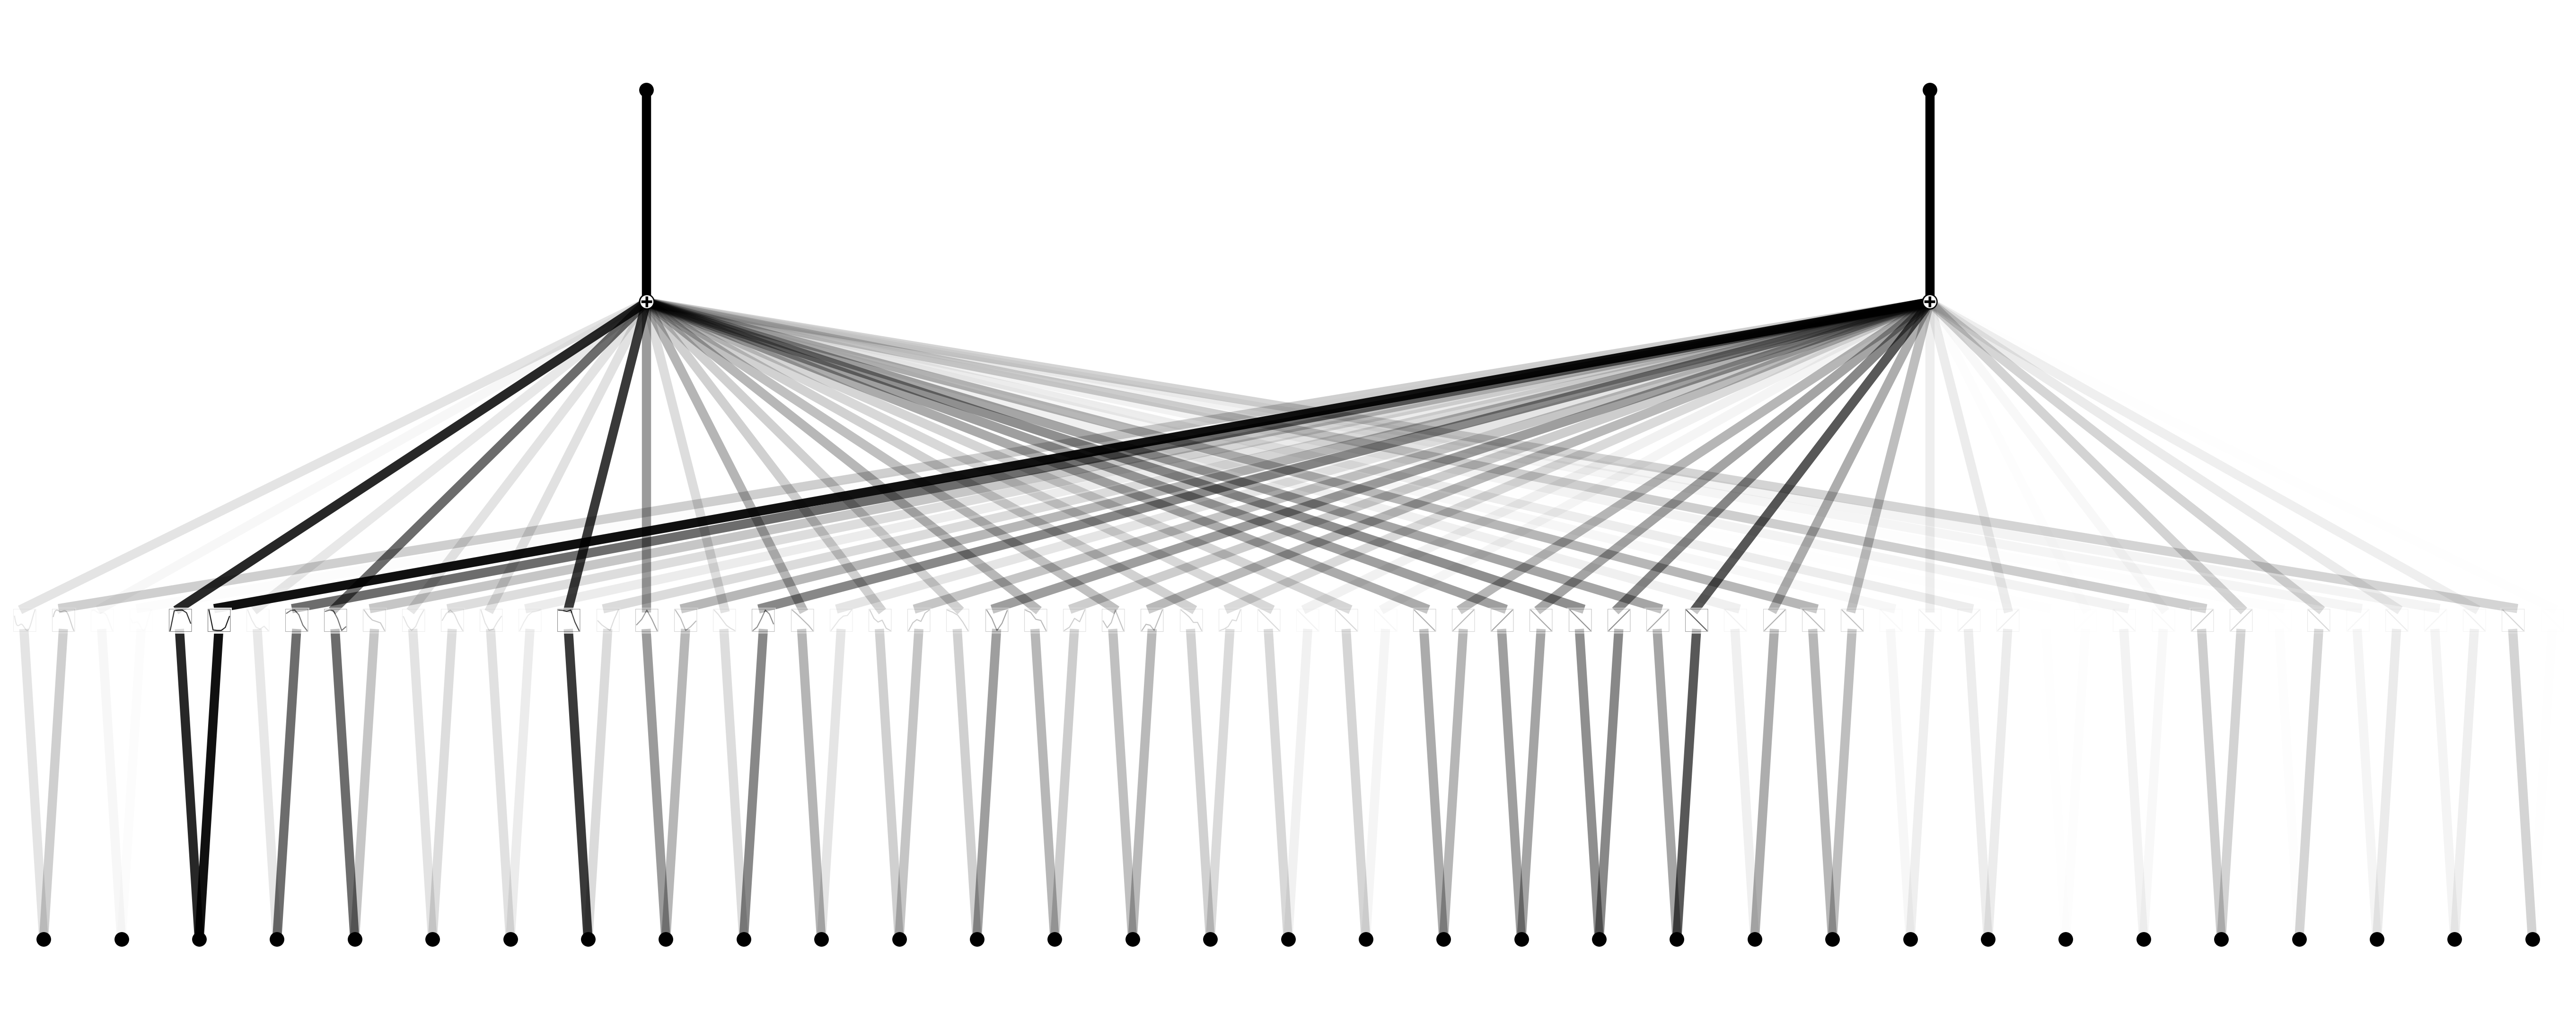

In [34]:
model.plot(scale=7)

veja que temos as seguintes colunas representadas da esquerda para a direita na representação acima do modelo KAN

In [33]:
pd.DataFrame(zip(range(len(train_df.columns)), train_df.columns.tolist()))

,0,1
0,0,Age
1,1,Flight Distance
2,2,Inflight wifi service
3,3,Departure/Arrival time convenient
4,4,Ease of Online booking
5,5,Gate location
6,6,Food and drink
7,7,Online boarding
8,8,Seat comfort
9,9,Inflight entertainment


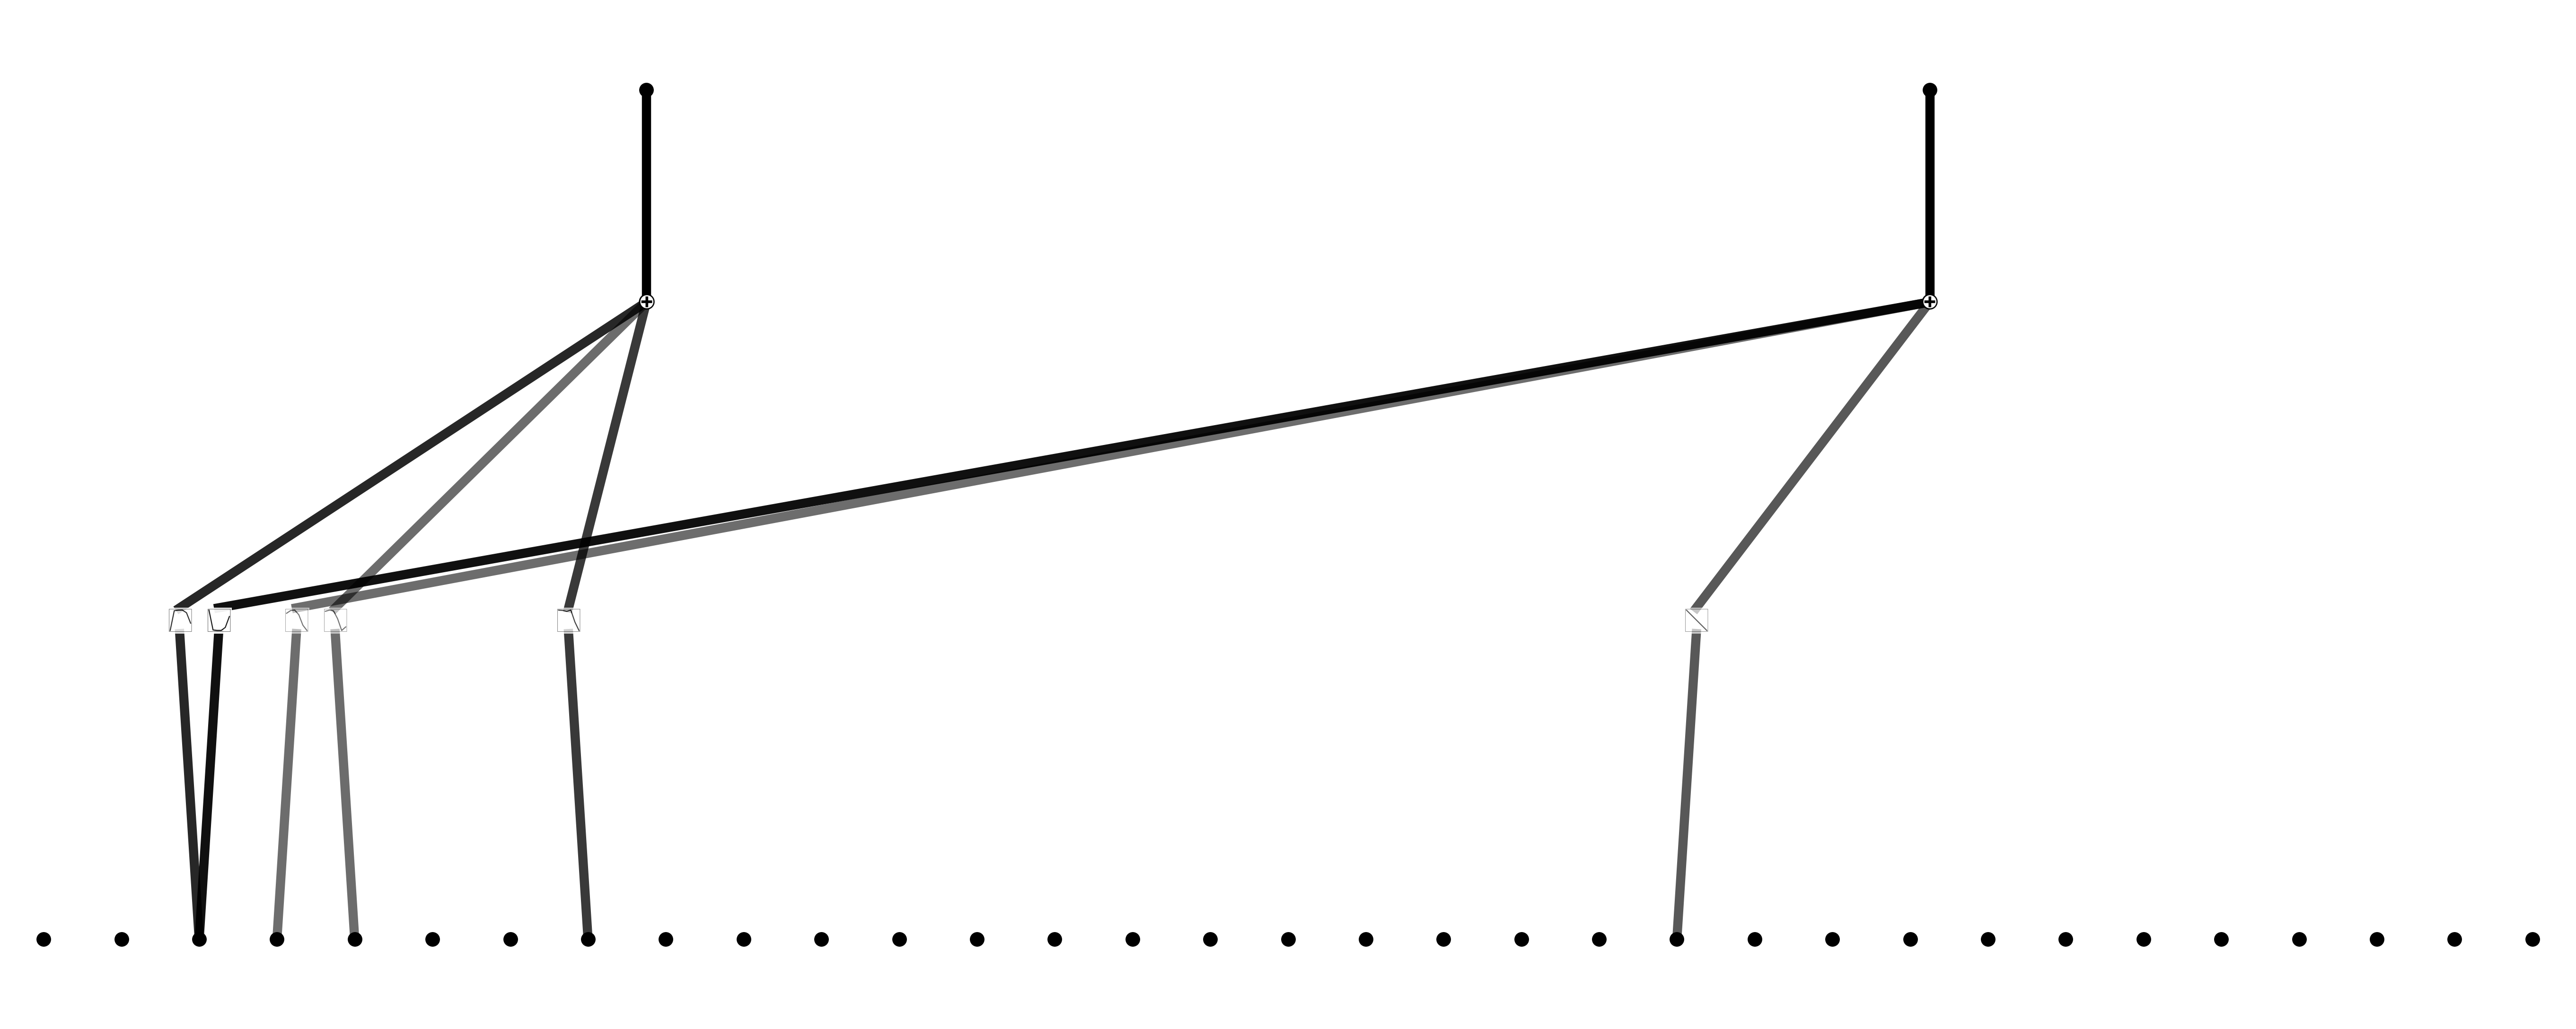

In [42]:
pruned_model = model.prune(node_th=0.01, edge_th=0.2)
pruned_model.plot(scale=7)

após ajustar o método de prunning, conseguimos perceber, por inspeção visual, que os parâmetros que a rede considerou mais importantes durante o treinamento em ordem decrescente de importância foram os de indice:

* 2 : Inflight wifi service
* 7 : Online boarding
* 21 : Type of Travel_Business travel
* 3 : Departure/Arrival time convenient
* 4 : Ease of Online booking


Haja vista o método de prunning da KAN ter considerado as features categóricas de forma particionada, vejamos o que obtemos se utilizar-mos o método de PFI com a implementação por nós desenvolvida que permite reagrupar as features categóricas separadas por one-hot encoding durante o calculo do PFI.

In [51]:
# Define as features numéricas (não passaram por one-hot encoding)
numerical_features = [
    'Age', 'Flight Distance', 'Inflight wifi service', 
    'Departure/Arrival time convenient', 'Ease of Online booking', 
    'Gate location', 'Food and drink', 'Online boarding', 
    'Seat comfort', 'Inflight entertainment', 'On-board service', 
    'Leg room service', 'Baggage handling', 'Checkin service', 
    'Inflight service', 'Cleanliness'
]

# Define os grupos de features categóricas baseadas no one-hot encoding
categorical_feature_groups = {
    'Customer Type': ['Customer Type_Loyal Customer', 'Customer Type_disloyal Customer'],
    'Class': ['Class_Business', 'Class_Eco', 'Class_Eco Plus'],
    'Type of Travel': ['Type of Travel_Business travel', 'Type of Travel_Personal Travel'],
    'Departure Delay Category': [
        'Departure Delay Category_10 minutos até 30 minutos', 
        'Departure Delay Category_30 min até 1 hora',
        'Departure Delay Category_Mais de 1 hora', 
        'Departure Delay Category_Menos de 10 minutos'],
    'Arrival Delay Category': [
        'Arrival Delay Category_10 minutos até 30 minutos', 
        'Arrival Delay Category_30 min até 1 hora',
        'Arrival Delay Category_Mais de 1 hora', 
        'Arrival Delay Category_Menos de 10 minutos'],
    'Gender': ['Gender_Female', 'Gender_Male']
}

In [53]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

# Função para converter numpy arrays para tensores do PyTorch
def to_tensor(data):
    return torch.tensor(data, dtype=torch.float32)

# Função para calcular PFI no modelo KAN
def compute_pfi_kan(model, X_test, y_test, numerical_features, categorical_groups, feature_names, metric=accuracy_score):
    """
    Calcula a Importância de Feature por Permutação (PFI) para um modelo KAN,
    considerando tanto features numéricas quanto categóricas (agrupadas para one-hot encoded).
    
    Args:
    - model: Modelo KAN treinado
    - X_test: Dataset de teste (numpy array ou DataFrame)
    - y_test: Labels verdadeiras (numpy array)
    - numerical_features: Lista de features numéricas
    - categorical_groups: Dicionário onde as chaves são os nomes originais das features categóricas, e os valores são listas de colunas one-hot encoded.
    - feature_names: Lista dos nomes das colunas de `X_test` (necessário para numpy array)
    - metric: Métrica de avaliação (padrão é accuracy_score)
    
    Returns:
    - importance_df: DataFrame com as importâncias das features
    """
    # Verificar se X_test é um DataFrame ou numpy array
    if isinstance(X_test, pd.DataFrame):
        X_test_tensor = to_tensor(X_test.values)  # DataFrame para tensor
        feature_names = X_test.columns.tolist()  # Extrair os nomes das colunas
    else:
        X_test_tensor = to_tensor(X_test)  # numpy array para tensor
    
    # Converter y_test para tensor PyTorch
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Compute original predictions and accuracy
    original_preds = model(X_test_tensor)
    original_score = metric(y_test, torch.argmax(original_preds, dim=1).numpy())

    feature_importances = {}

    # Permutando as features numéricas individualmente
    for feature in numerical_features:
        # Obter o índice da feature no numpy array
        feature_idx = feature_names.index(feature)
        
        X_permuted = X_test.copy()
        
        # Permuta a coluna numérica usando o índice
        X_permuted[:, feature_idx] = shuffle(X_permuted[:, feature_idx], random_state=42)
        
        # Converter para tensor PyTorch
        X_permuted_tensor = to_tensor(X_permuted)
        
        # Predição com dataset permutado
        permuted_preds = model(X_permuted_tensor)
        permuted_score = metric(y_test, torch.argmax(permuted_preds, dim=1).numpy())
        
        # A importância é a diferença entre a métrica original e a métrica permutada
        feature_importances[feature] = original_score - permuted_score

    # Permutando as features categóricas como grupos
    for feature, columns in categorical_groups.items():
        # Obter os índices das colunas one-hot correspondentes
        column_indices = [feature_names.index(col) for col in columns]
        
        X_permuted = X_test.copy()
        
        # Permuta todas as colunas one-hot correspondentes a essa feature
        X_permuted[:, column_indices] = shuffle(X_permuted[:, column_indices], random_state=42)
        
        # Converter para tensor PyTorch
        X_permuted_tensor = to_tensor(X_permuted)
        
        # Predição com dataset permutado
        permuted_preds = model(X_permuted_tensor)
        permuted_score = metric(y_test, torch.argmax(permuted_preds, dim=1).numpy())
        
        # A importância é a diferença entre a métrica original e a métrica permutada
        feature_importances[feature] = original_score - permuted_score

    # Converte para DataFrame para melhor visualização
    importance_df = pd.DataFrame(list(feature_importances.items()), columns=['Feature', 'Importance'])
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    return importance_df

# Lista de nomes de colunas para X_test (necessário para numpy array)
feature_names = numerical_features + [col for group in categorical_feature_groups.values() for col in group]

# Chame a função para calcular PFI
importance_df = compute_pfi_kan(model=model, X_test=X_test, y_test=y_test, 
                                numerical_features=numerical_features, 
                                categorical_groups=categorical_feature_groups,
                                feature_names=feature_names)

# Mostra as importâncias calculadas
print(importance_df)


                              Feature  Importance
2               Inflight wifi service    0.111372
17                              Class    0.051791
18                     Type of Travel    0.041615
7                     Online boarding    0.030695
8                        Seat comfort    0.008636
3   Departure/Arrival time convenient    0.008238
9              Inflight entertainment    0.007122
14                   Inflight service    0.005531
12                   Baggage handling    0.005313
13                    Checkin service    0.004222
4              Ease of Online booking    0.003696
11                   Leg room service    0.003529
10                   On-board service    0.003105
15                        Cleanliness    0.001745
5                       Gate location    0.001617
0                                 Age    0.001309
6                      Food and drink    0.000436
21                             Gender    0.000334
20             Arrival Delay Category    0.000167


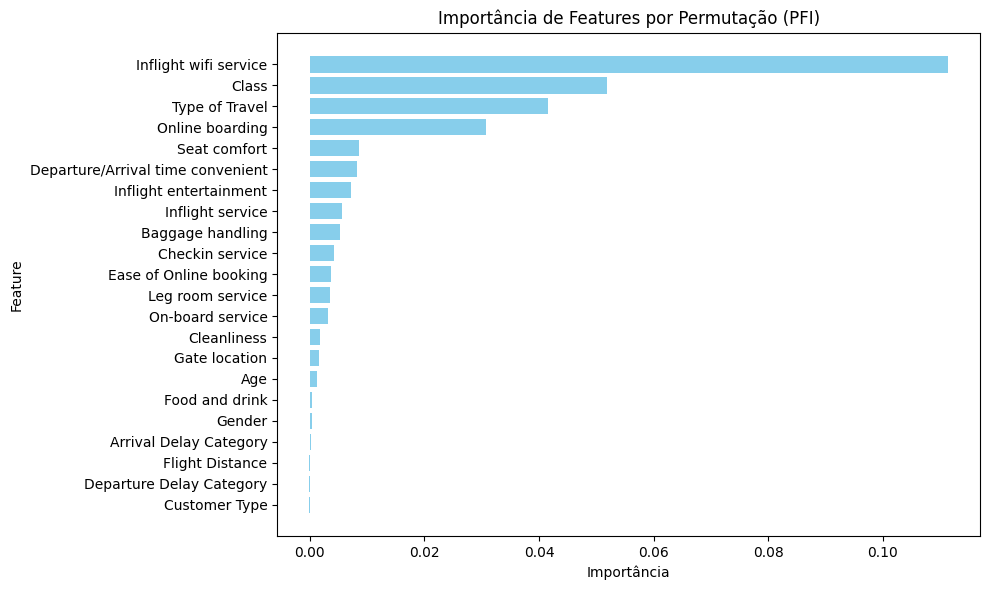

In [54]:
import matplotlib.pyplot as plt

def plot_pfi(importance_df):
    """
    Plota um gráfico de barras para a Importância de Feature por Permutação (PFI).
    
    Args:
    - importance_df: DataFrame contendo as colunas 'Feature' e 'Importance'
    """
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Importância')
    plt.ylabel('Feature')
    plt.title('Importância de Features por Permutação (PFI)')
    plt.gca().invert_yaxis()  # Inverte o eixo para a maior importância aparecer no topo
    plt.tight_layout()
    plt.show()

# Exemplo: Substitua pela sua tabela 'importance_df' real
plot_pfi(importance_df)

Como podemos perceber, o método do PFI mostrou uma correlação positiva com o pruning da rede KAN no sentido de apontar as features "inflight wi-fi service", "online boarding", "Type of Travel" entre as features mais importantes para a classificação do modelo mas os métodos entram conflito quanto a importancia da feature "Ease of Online booking". Uma reflexão que pode ser feita  respeito do PFI é que consideramos a im features categóricas de forma agrupada enquanto no método de pruning a importancia dessas features é extraída de forma isolada para cada categoria. Isso ainda não explica tamanha distinção quanto a feature "Ease of Online booking". O que sugere que uma análise da tecnica de pruning é necessária para entendermos melhor o porquê dessa diferença. 